In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer

from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, DropMissingData
from feature_engine.encoding import OrdinalEncoder, RareLabelEncoder, CountFrequencyEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures

#### Cargamos datos

In [36]:
datalab = pd.read_csv('train.csv')
datalab.head()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN


In [37]:
datalab.shape
#vemos que hay 11 columnas con 14447 datos

(14447, 11)

#### 1. Columnas con faltantes

In [38]:
#A estas columnas tenemos que hacerle algún tipo de imputación
cols_NaN = [col for col in datalab.columns if(datalab[col].isnull().mean()>0)]
cols_NaN
#vemos que solo hay una columna con datos faltantes

['total_bedrooms']

In [39]:
# necesitamos conocer el tipo de datos de cada columna
# si son numeros, la imputacion se hace de una forma y si son string se hace de otra forma
datalab[cols_NaN].dtypes

total_bedrooms    float64
dtype: object

#### 2. Proporción de faltantes

In [40]:
#Buscamos el porcentaje de NaN que tienen cada columna
#Un 5% es el maximo para hacer imputacion, mas de eso no vale la pena.
prop_NaN = datalab[cols_NaN].isnull().mean()*100
prop_NaN
#La unica columna con NaN tiene un 0.94% de faltantes, es util para hacer imputacion

total_bedrooms    0.948294
dtype: float64

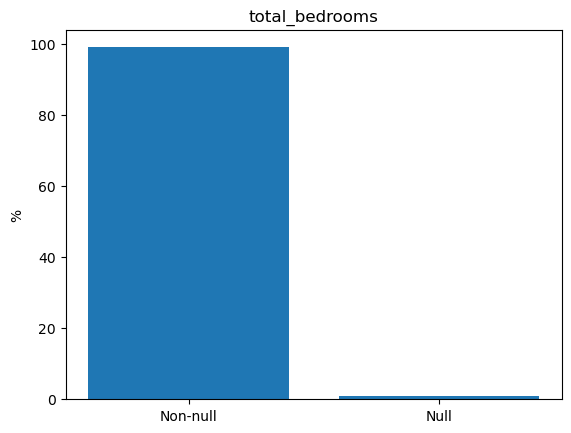

In [41]:
fig, ax = plt.subplots()
ax.bar(['Non-null', 'Null'], [(datalab['total_bedrooms'].count()/ len(datalab.index))*100, datalab['total_bedrooms'].isnull().mean()*100])

ax.set_ylabel('%')
ax.set_title('total_bedrooms')

plt.show()

#### 3. Imputación de variables numéricas

In [42]:
#Observamos como se ve la tabla con los datos de todas las columnas teniendo solo faltantes de total_bedrooms
datalab[datalab['total_bedrooms'].isnull()]

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
18,5655,-118.30,33.73,42,1731,NaN,866,403,2.7451,255400.0,NEAR OCEAN
379,3959,-118.59,34.20,21,1789,NaN,2300,677,2.7540,179800.0,<1H OCEAN
605,4692,-118.37,34.07,50,2519,NaN,1117,516,4.3667,405600.0,<1H OCEAN
743,4668,-118.29,34.05,34,1102,NaN,1325,439,1.5972,168800.0,<1H OCEAN
923,10217,-117.91,33.87,29,1121,NaN,762,276,2.5000,143800.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...,...
14162,1457,-121.98,37.96,22,2987,NaN,1420,540,3.6500,204100.0,INLAND
14235,14153,-117.09,32.77,31,3062,NaN,1263,539,3.0875,291500.0,NEAR OCEAN
14273,16106,-122.50,37.75,44,1819,NaN,1137,354,3.4919,271800.0,NEAR OCEAN
14275,19933,-119.33,36.30,11,3045,NaN,1563,516,5.4337,133800.0,INLAND


In [43]:
#Observamos como estan distribuidos los datos de la única columna con datos categóricos, de todo el dataset y solo conteniendo NaNs
datalab.describe(include='object')

,ocean_proximity
count,14447
unique,5
top,<1H OCEAN
freq,6384


In [44]:
#Vemos que se mantiene la misma tendencia
datalab[datalab['total_bedrooms'].isnull()].describe(include='object')

,ocean_proximity
count,137
unique,4
top,<1H OCEAN
freq,64


In [45]:
#Observamos como estan distribuidos los datos de las columnas numéricas, de todo el dataset y solo conteniendo NaNs
datalab.describe()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14310.000000,14447.000000,14447.000000,14447.000000,14447.000000
mean,10275.451997,-119.580422,35.642011,28.845435,2635.287534,537.778756,1425.171454,500.116772,3.863949,206873.687824
std,5957.136373,2.003511,2.135526,12.585221,2215.285809,424.012399,1123.733449,386.181946,1.892919,115263.889710
min,1.000000,-124.300000,32.540000,1.000000,2.000000,1.000000,6.000000,1.000000,0.499900,14999.000000
25%,5139.500000,-121.805000,33.930000,18.000000,1444.000000,295.000000,786.000000,280.000000,2.567150,119600.000000
50%,10210.000000,-118.500000,34.260000,29.000000,2121.000000,433.000000,1163.000000,408.000000,3.535000,179700.000000
75%,15449.000000,-118.020000,37.720000,37.000000,3137.500000,647.000000,1722.000000,604.500000,4.722850,264600.000000
max,20640.000000,-114.310000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


In [46]:
#Con un rápido vistazo vemos que se mantienen las tendencias, 
#los minimos y maximos son menores y mayores, respectivamente, en la tabla completa
datalab[datalab['total_bedrooms'].isnull()].describe()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,137.000000,137.000000,137.000000,137.000000,137.000000,0.0,137.000000,137.000000,137.000000,137.000000
mean,10853.014599,-119.711606,35.667591,28.313869,2652.583942,NaN,1534.248175,529.204380,3.859658,206074.474453
std,6284.349388,2.029241,2.141623,12.208815,1845.678767,NaN,1157.226526,417.799015,1.859350,106213.038697
min,342.000000,-124.130000,32.660000,5.000000,154.000000,NaN,37.000000,16.000000,1.225400,54600.000000
25%,4744.000000,-121.950000,33.990000,18.000000,1375.000000,NaN,797.000000,271.000000,2.634300,135200.000000
50%,10886.000000,-119.110000,34.410000,29.000000,2264.000000,NaN,1169.000000,439.000000,3.467900,182400.000000
75%,16331.000000,-118.020000,37.600000,37.000000,3674.000000,NaN,1919.000000,647.000000,4.714700,264600.000000
max,20485.000000,-116.660000,40.920000,52.000000,11709.000000,NaN,7604.000000,3589.000000,11.297900,500001.000000


#### 3.1 Imputación CCA

In [47]:
#Habiendo realizado ese pequeño análisis se decide hacer la imputación CCA
#Esto debido a que al eliminar completamente las filas que contienen NaN, no perdemos valiosa información.

datalab_trim = datalab.dropna().reset_index(drop=True)
datalab_trim.to_csv('data trimmed.csv', index=False)
datalab_trim.shape

(14310, 11)

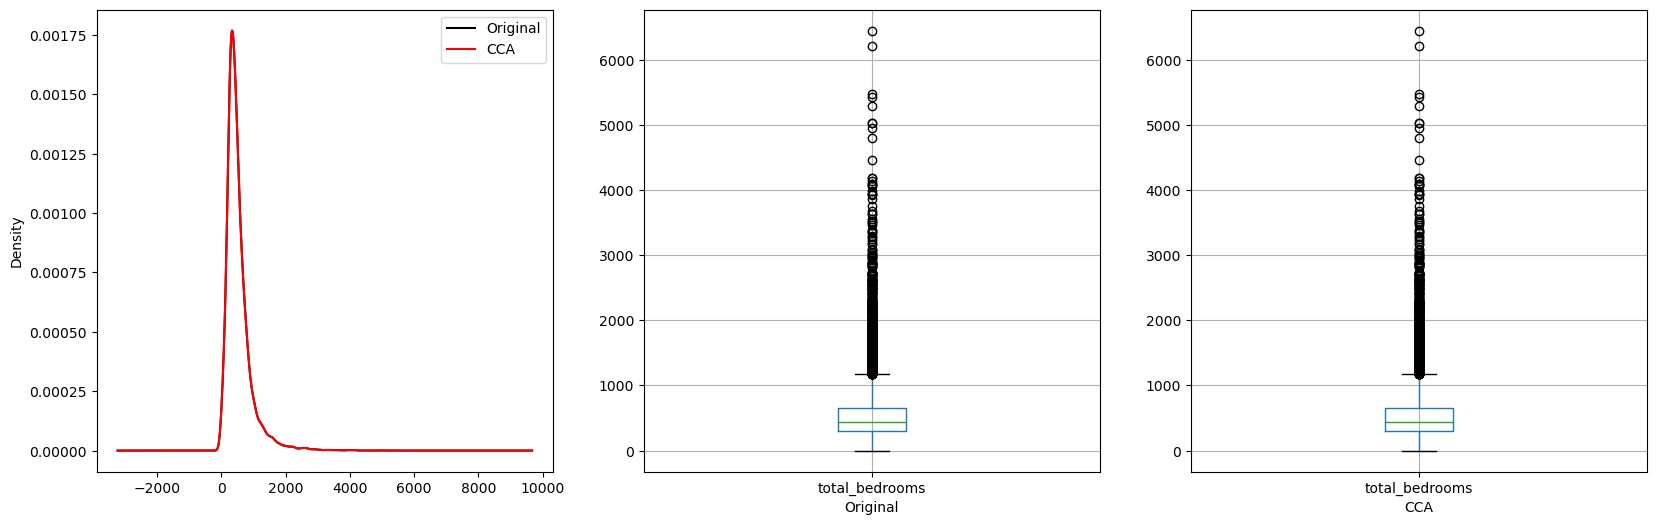

In [48]:
#Comprobamos gráficamente que las tendencias se mantienen igual.

fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
datalab['total_bedrooms'].plot.density(color='black', label='Original')
datalab_trim['total_bedrooms'].plot.density(color='red', label='CCA')
plt.legend()

plt.subplot(1,3,2)
datalab[['total_bedrooms']].boxplot().set_xlabel('Original')

plt.subplot(1,3,3)
datalab_trim[['total_bedrooms']].boxplot().set_xlabel('CCA')
plt.show()

#### 4. Imputación de variables categóricas

In [49]:
#No hay datos faltantes en la única variable categórica del dataset

#### 5. Codificación de variables categóricas

In [50]:
#Verificamos las clases que contiene la variable

datalab_trim['ocean_proximity'].value_counts()

<1H OCEAN     6320
INLAND        4542
NEAR OCEAN    1844
NEAR BAY      1602
ISLAND           2
Name: ocean_proximity, dtype: int64

In [51]:
#Ya que solo tiene 5 clases, vamos a realizar un One Hot Encoder, el cual es util para modelos lineales.

#Creamos instancia OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(datalab_trim[['ocean_proximity']])

#Creamos un nuevo dataframe con la data codificada, acortamos el nombre a op en lugar de ocean_proximity
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['ocean_proximity']))
encoded_df.columns = ['op_' + col.split('_')[-1] for col in encoded_df.columns]

#Unimos los dataset
datalab_encode = datalab_trim.join(encoded_df)

#verificamos que se hayan codificado correctamente, ahora todas son variables numéricas
datalab_encode


,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,op_<1H OCEAN,op_INLAND,op_ISLAND,op_NEAR BAY,op_NEAR OCEAN
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND,0.0,1.0,0.0,0.0,0.0
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14305,557,-122.25,37.77,43,4329,1110.0,2086,1053,2.9750,243400.0,NEAR BAY,0.0,0.0,0.0,1.0,0.0
14306,16090,-122.48,37.71,43,3850,1018.0,1497,829,3.5296,400000.0,NEAR OCEAN,0.0,0.0,0.0,0.0,1.0
14307,9083,-118.17,34.69,12,4881,803.0,2188,724,4.1667,171900.0,INLAND,0.0,1.0,0.0,0.0,0.0
14308,13138,-121.44,38.47,5,5666,1178.0,3139,1131,3.3608,108900.0,INLAND,0.0,1.0,0.0,0.0,0.0


In [52]:
#eliminamos la columna categorica y el id que no es util
datalab_encode = datalab_encode.drop(['ocean_proximity','id'], axis=1)
datalab_encode.to_csv('data encoded.csv', index=False)

#### 6. Transformación de variables continuas

In [53]:
#Establecemos la variables para verificar la trasnformación, exceptuando el precio.
continuas = ['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

c:\Users\pablo\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


--------longitude---------


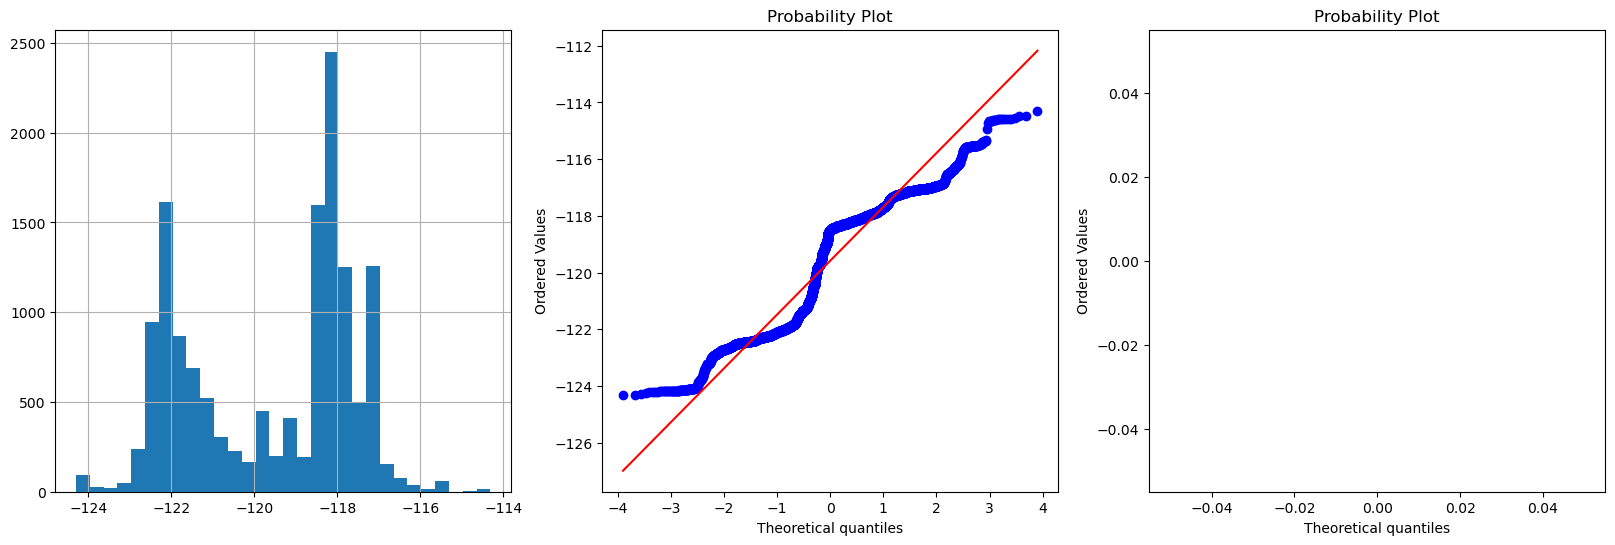

--------latitude---------


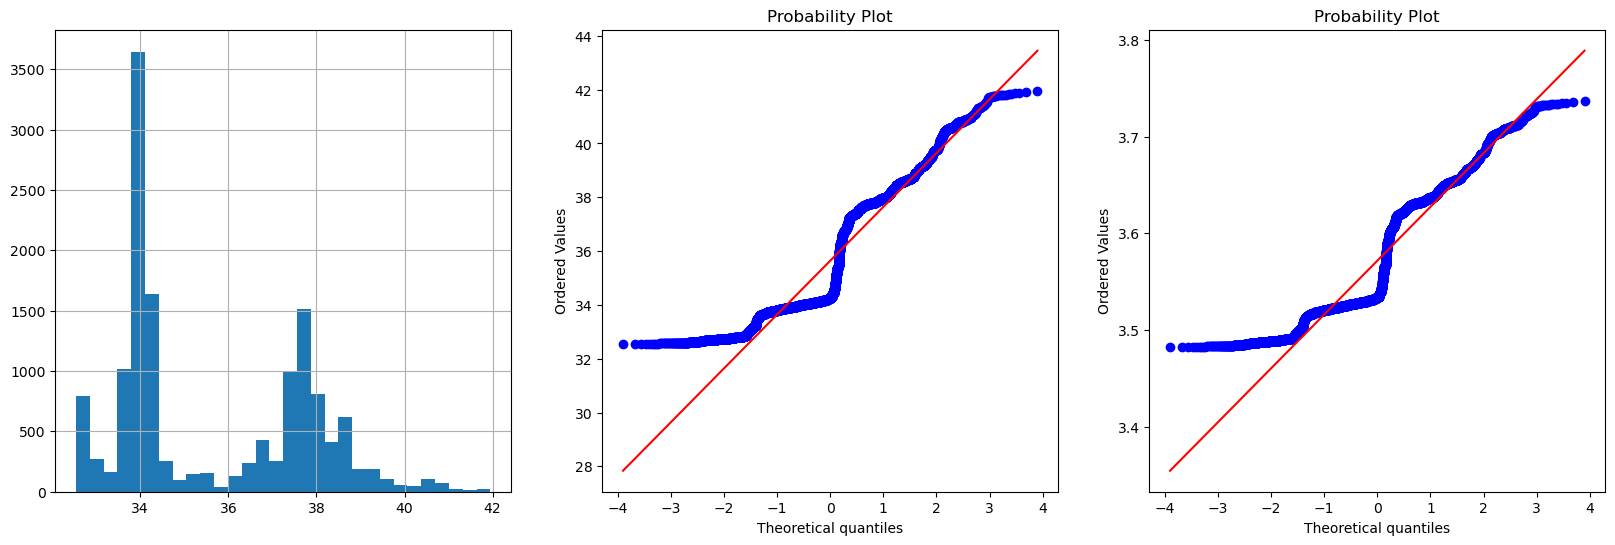

--------housing_median_age---------


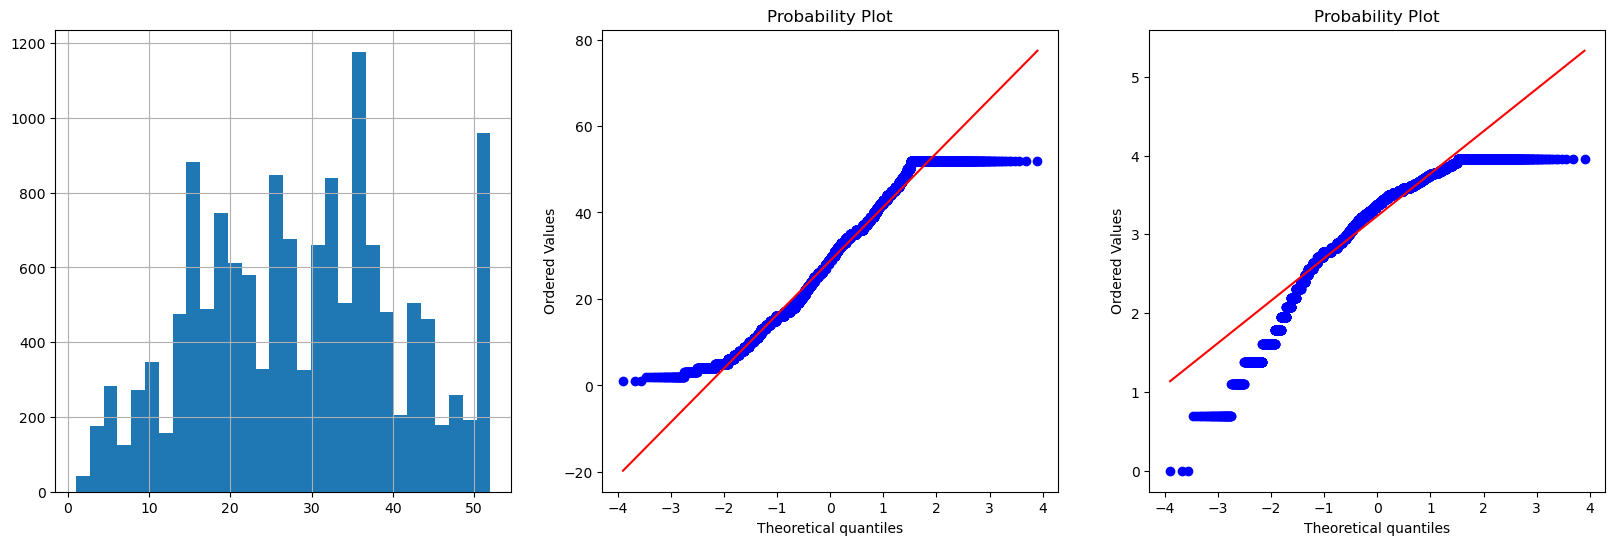

--------total_rooms---------


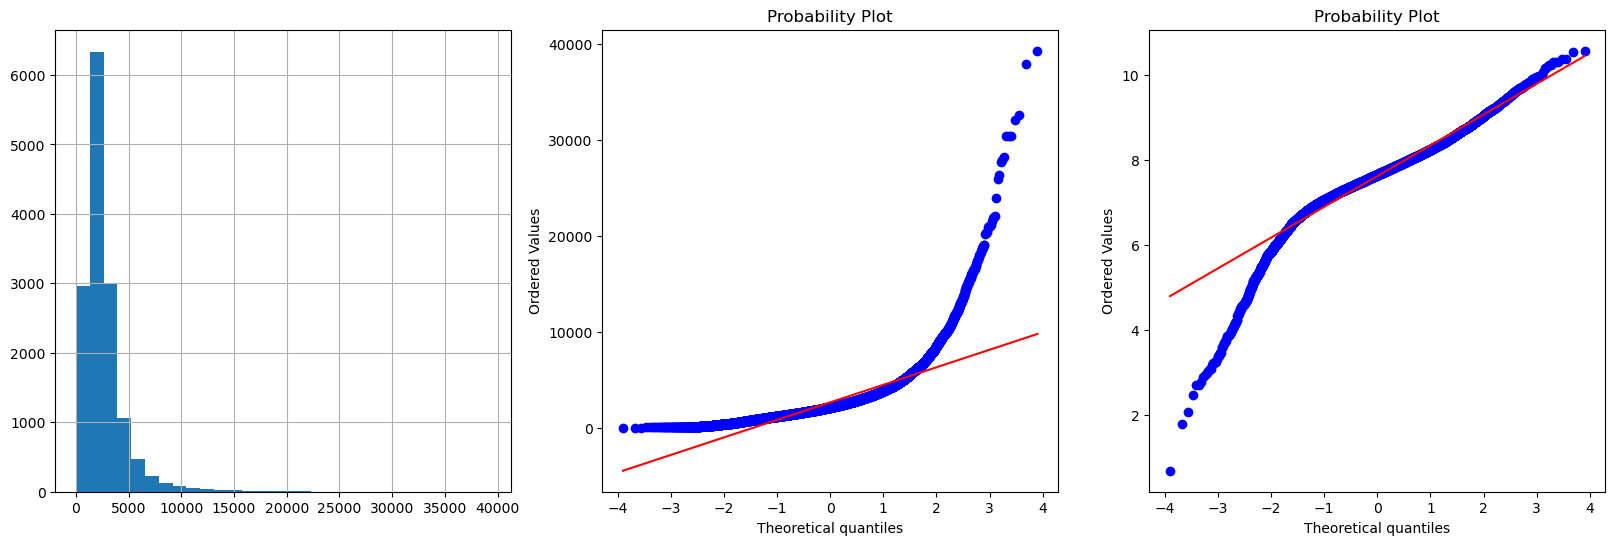

--------total_bedrooms---------


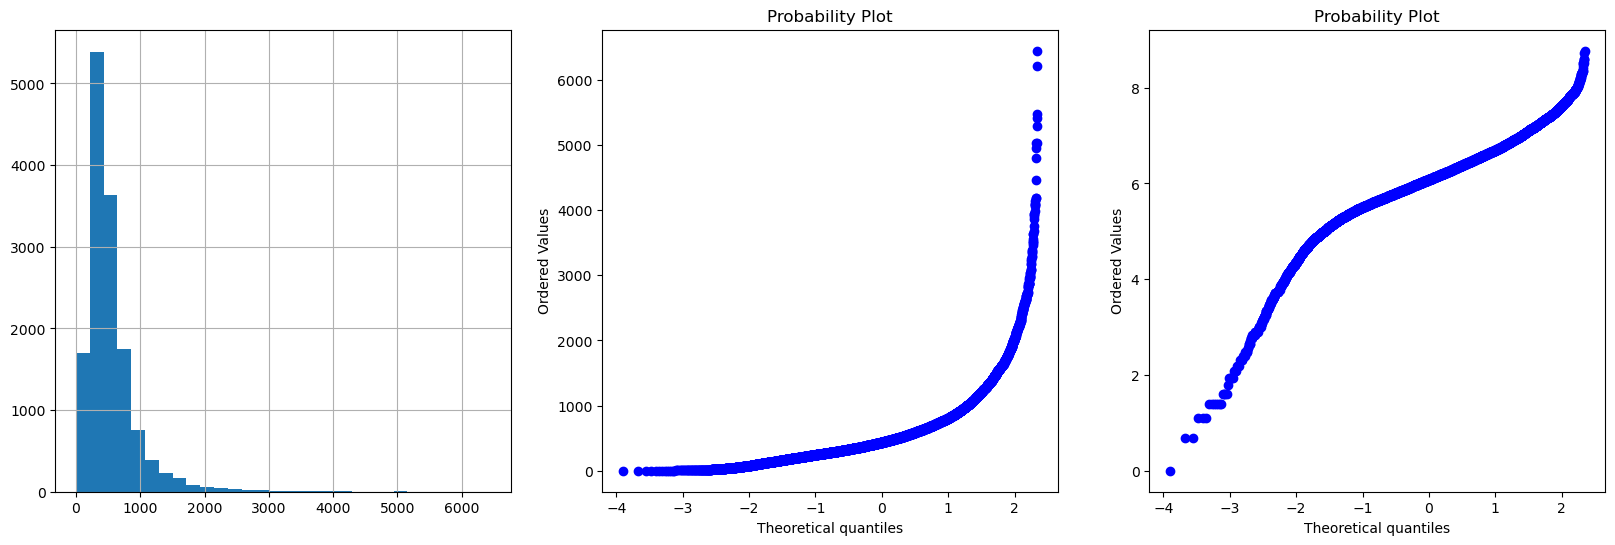

--------population---------


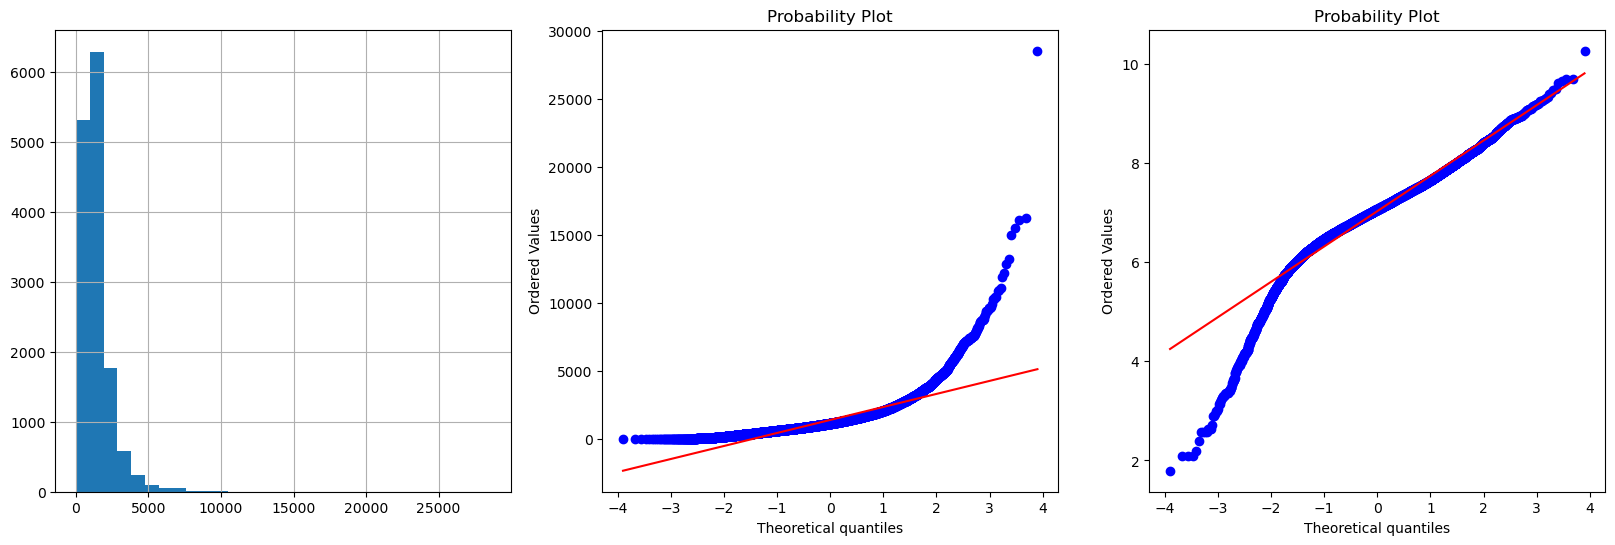

--------households---------


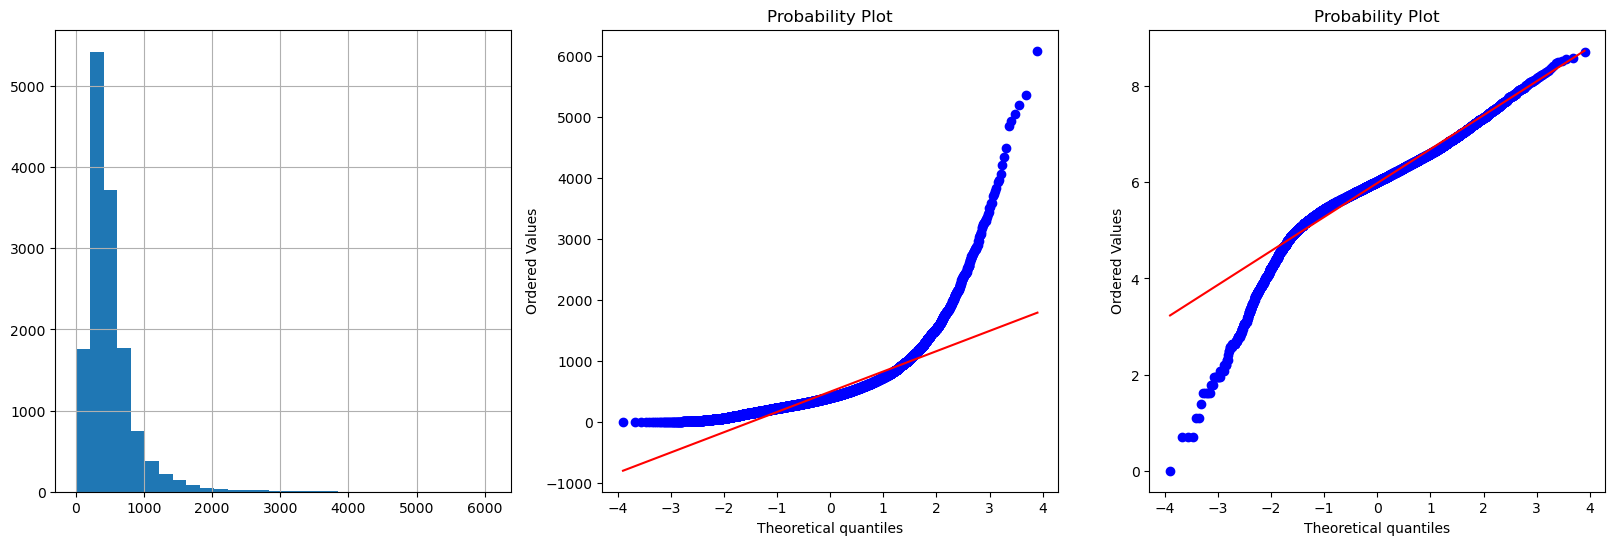

--------median_income---------


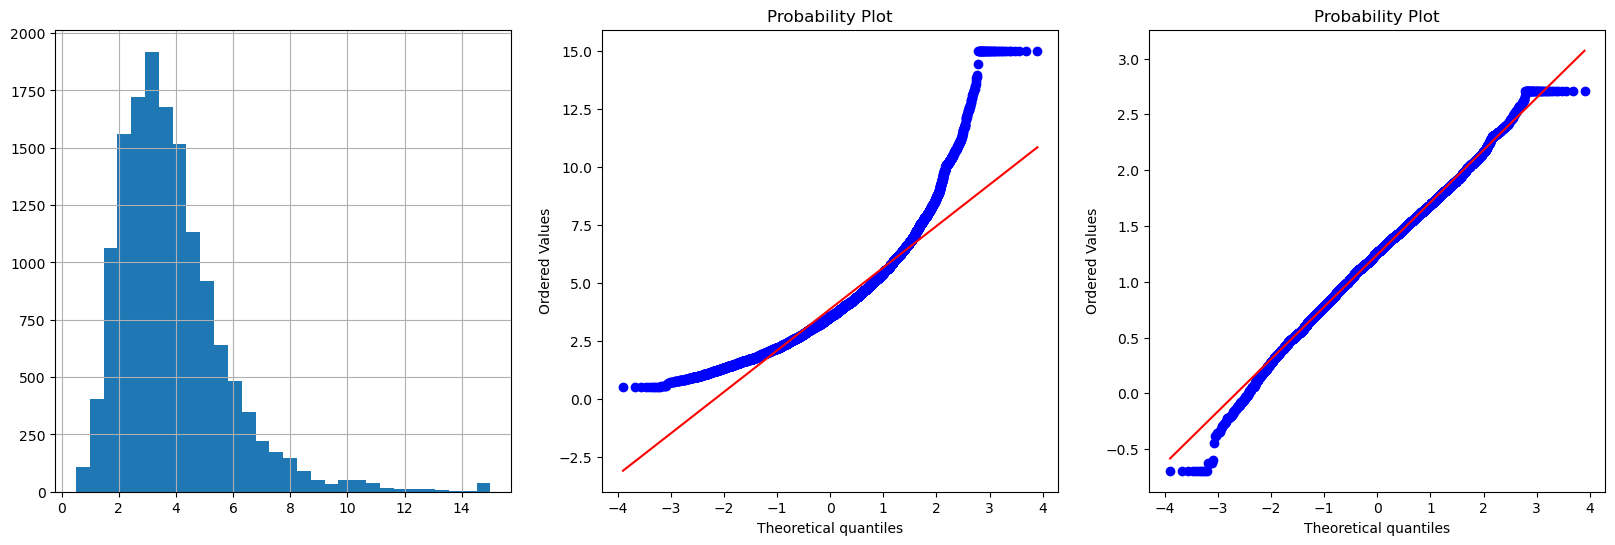

In [54]:
for col in continuas:

    col_name= f'{col}_log'
    
    datalab[col_name] = np.log(datalab[col])

    print(f'--------{col}---------')

    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    datalab[col].hist(bins=30)
    plt.subplot(1,3,2)
    stats.probplot(datalab[col], dist='norm', plot=plt)
    plt.subplot(1,3,3)
    stats.probplot(datalab[col_name], dist='norm', plot=plt)
    plt.show()

#No se le puede hacer transformación logarítmica a ninguna

#### 7. Feature Scaling

In [55]:
#Hacemos una copia de la data
datalab_temp = datalab_encode.copy()

#Establecemos el scaler
scaler = StandardScaler()
scaler.fit(datalab_temp)

datalab_scaled = scaler.transform(datalab_temp) #hace la transformacion como calcular Z
datalab_scaled = pd.DataFrame(datalab_scaled, columns=datalab_temp.columns)

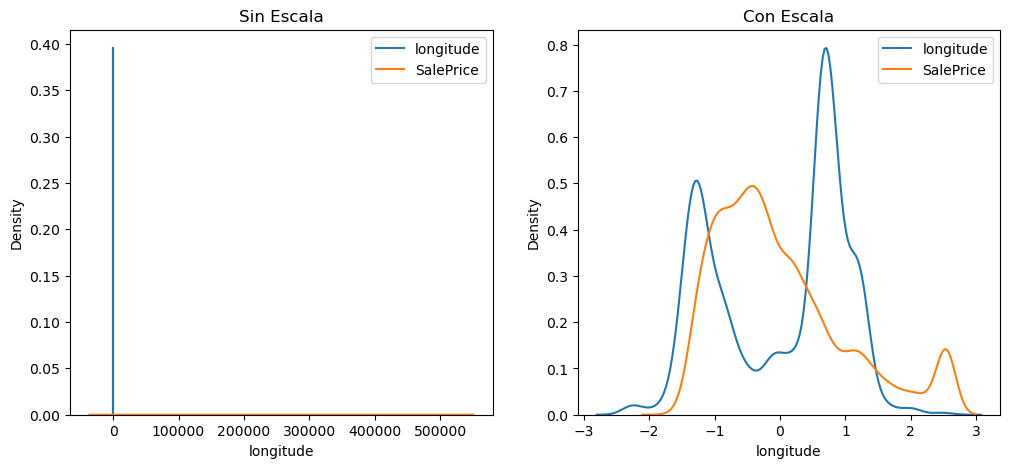

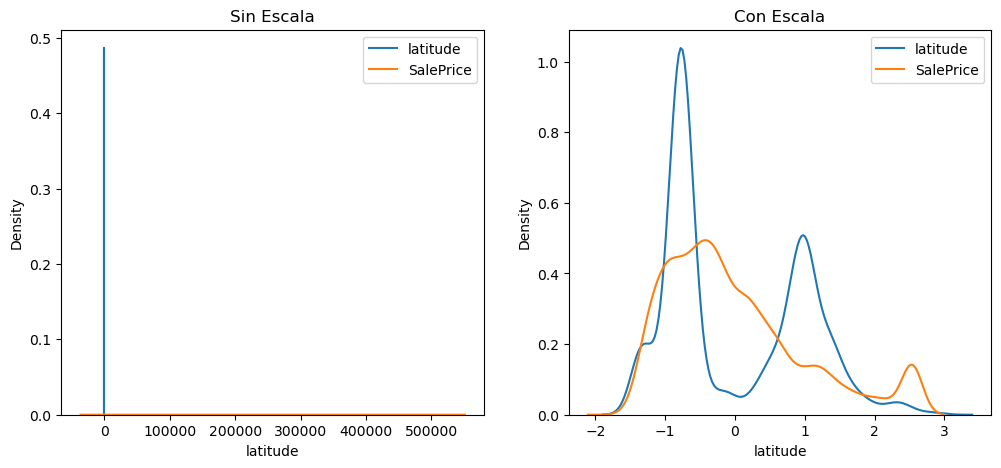

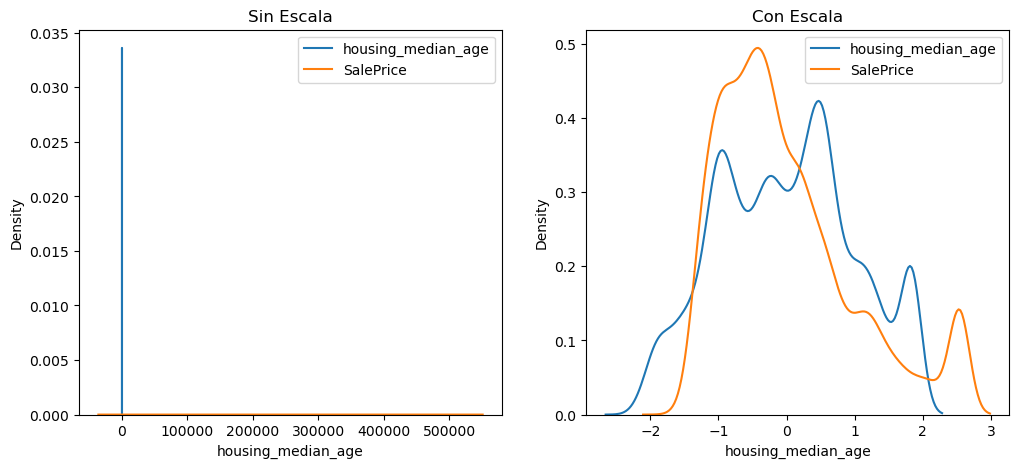

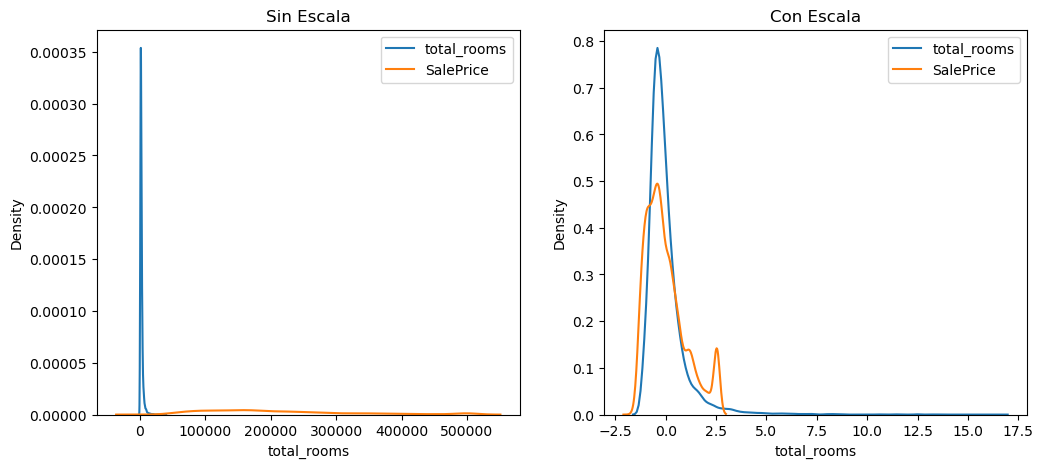

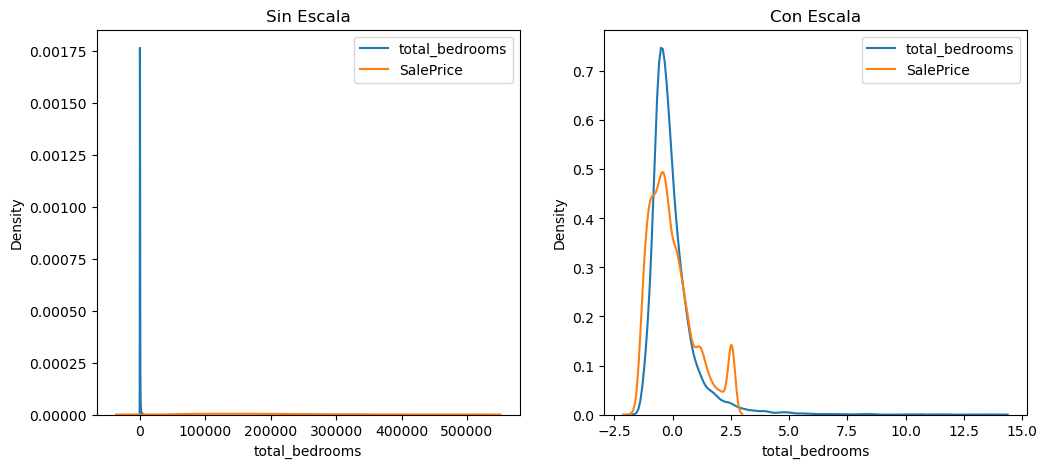

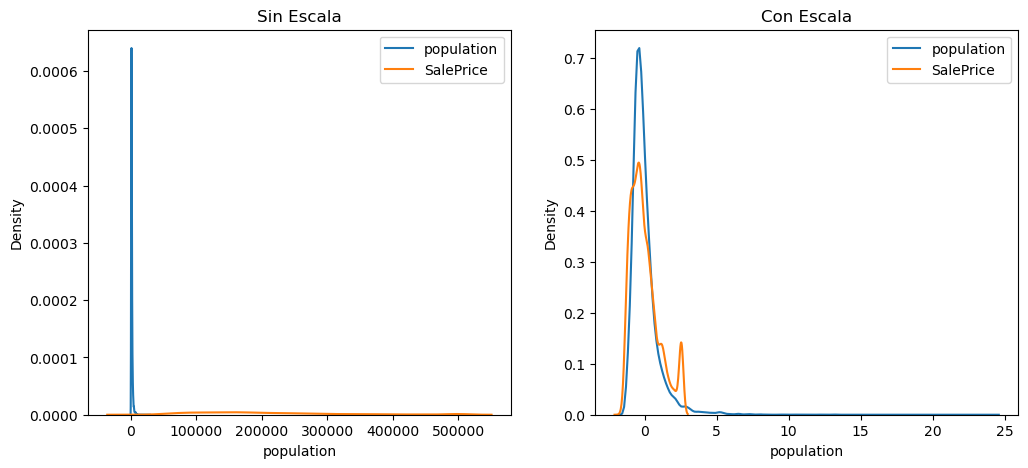

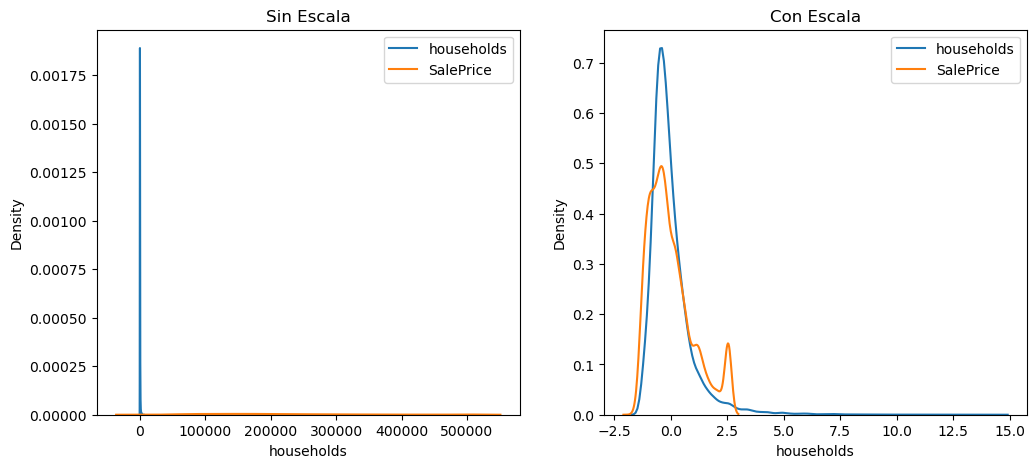

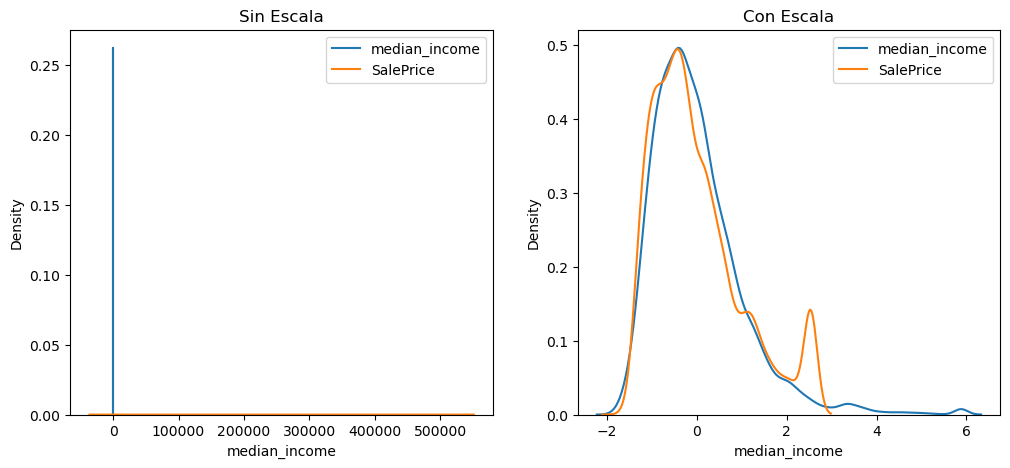

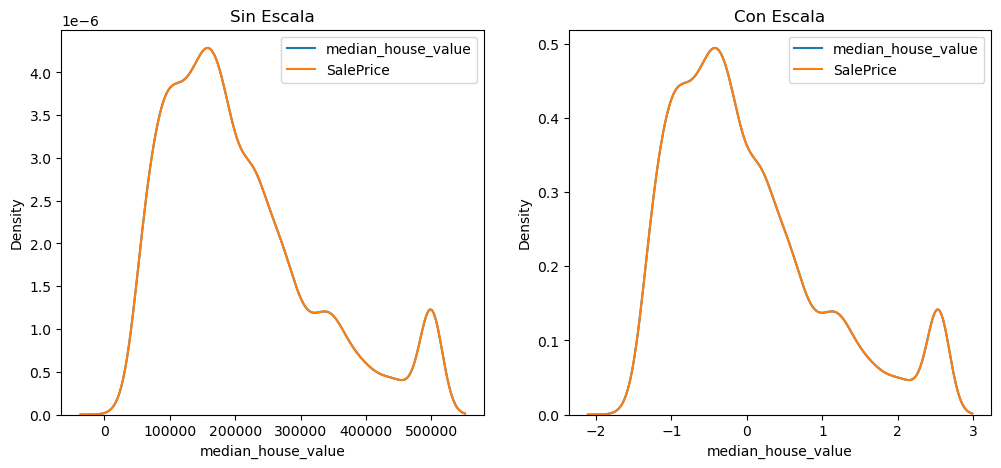

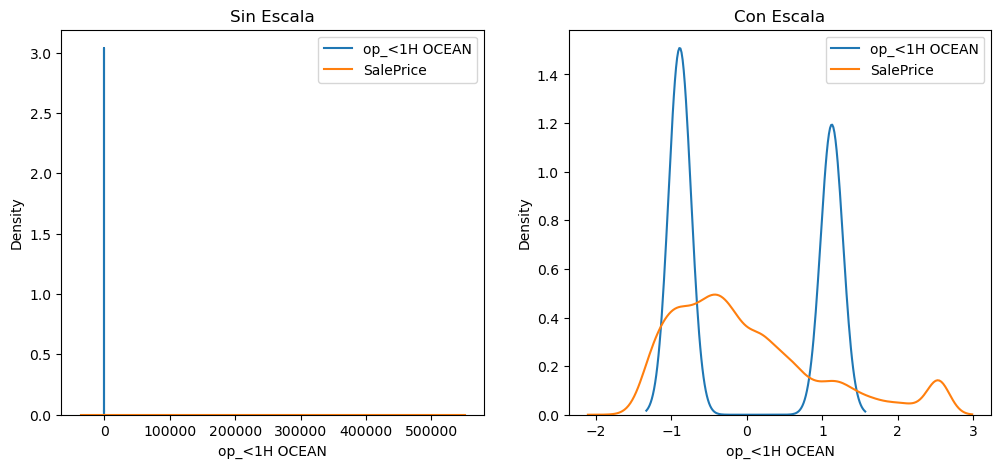

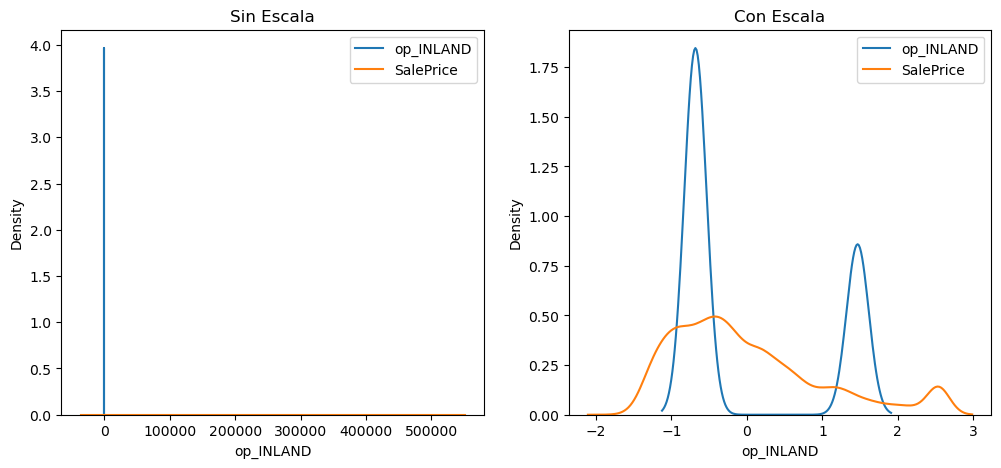

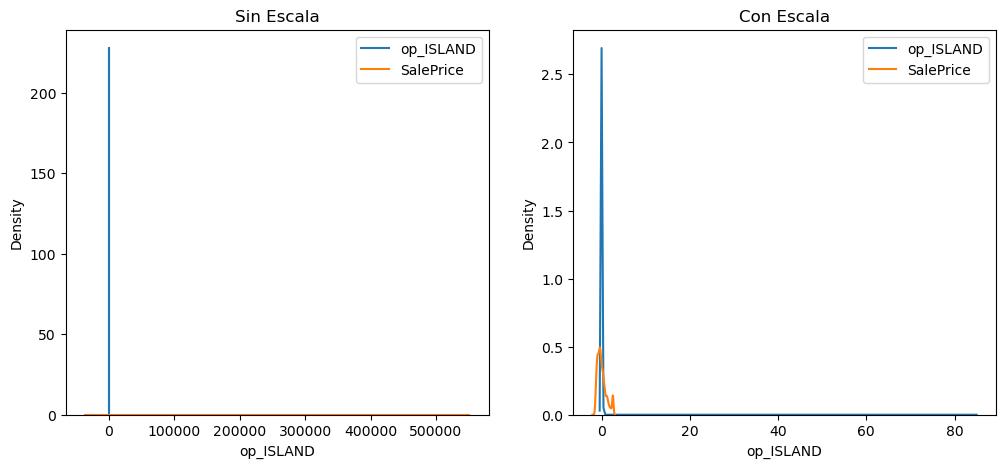

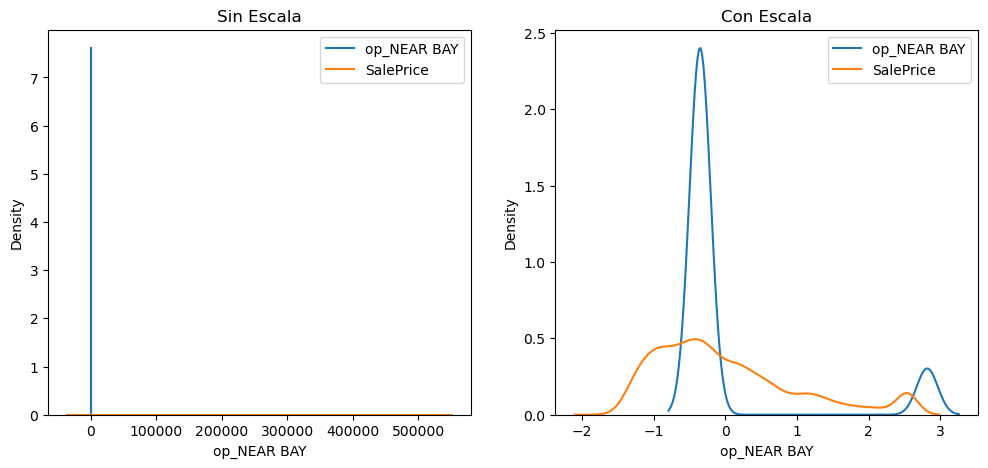

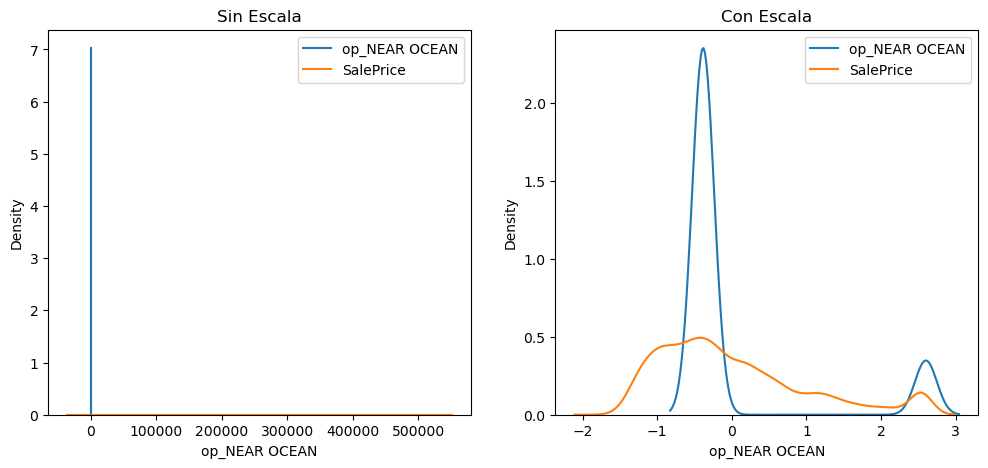

In [56]:
#Graficamos para verificar si hay algun cambio respecto al precio de venta

for col in datalab_temp.columns:

    fig, (ax1,ax2)=plt.subplots(ncols=2, figsize=(12,5))

    ax1.set_title("Sin Escala")
    sns.kdeplot(datalab_temp[col], ax=ax1, label=col)
    sns.kdeplot(datalab_temp['median_house_value'], ax=ax1, label="SalePrice")

    ax2.set_title("Con Escala")
    sns.kdeplot(datalab_scaled[col], ax=ax2, label=col)
    sns.kdeplot(datalab_scaled['median_house_value'], ax=ax2, label="SalePrice")

    ax1.legend()
    ax2.legend()

    plt.show()

#### 8. Separamos datos de Entrenamiento y datos de Prueba

In [57]:
X_train, X_test, y_train, y_test = train_test_split(datalab_encode.drop(['median_house_value'], axis=1),
                                                                     datalab_encode['median_house_value'],test_size=0.3,
                                                                     random_state=2023)

#cuidar el orden en que se colocan las variables
# X mayuscula generalmente indica que es una matriz con varias columnas, y minuscula es que solo tiene una columna

#### 9. Configuracion del Pipeline

In [58]:
#imputación de variables categóricas
CATEGORICAL_VARS_WITH_NA = []

#Imputación de variables numéricas
NUMERICAL_VARS_WITH_NA = ['total_bedrooms']

#Variables que eliminaremos
DROP_FEATURES = ['ocean_proximity','id']

#Variables para transfomraicón logarítmica
NUMERICAL_LOG_VARS = []

#Variables para codificación One Hot Encode
ENCODE_VARS = ['ocean_proximity']

#Variables a utilzar en el entrenamiento
FEATURES = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'op_<1H OCEAN', 
    'op_INLAND', 
    'op_ISLAND',
    'op_NEAR BAY', 
    'op_NEAR OCEAN']


#### 10. Seleccionamos Variables de Interes

In [59]:
X_train = X_train[FEATURES]

#### 11. Tratar la Variable Target

In [60]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [61]:
#Importamos OneHotEncoder
from feature_engine.encoding import OneHotEncoder

#### 12. Construccion del Pipeline  

In [62]:
lab3_pipeline_v11062023=Pipeline([
        # =========== IMPUTACIONES ==============

        #1. Imputacion de Variables Numericas

        ('miss_imputation',
                DropMissingData(variables=NUMERICAL_VARS_WITH_NA)),
        

        #2. Codificacion de Variables Categoricas

        ('onehotencoder', 
                OneHotEncoder(variables=ENCODE_VARS)),
        

        #3. Feature Scaling

        ('scaler',
                MinMaxScaler())


])

#el pipeline es una estructura especifica que funciona de manera secuencial, lo primero que se hace se propaga en las siguientes

In [63]:
lab3_pipeline_v11062023.fit(X_train,y_train)

KeyError: "None of [Index(['ocean_proximity'], dtype='object')] are in the [columns]"